In [1]:
from rdkit import Chem
import sys
import os
import useful_rdkit_utils as uru
from rdkit.Chem.Draw import MolsToGridImage
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem import Descriptors
import matplotlib.pyplot as plt
import itertools
import pandas as pd
from collections import Counter
import mols2grid
from tdc.single_pred import ADME
from Filtering_functions import filter_molecules
import glob
from rdkit.Chem import inchi
import molvs
from multiprocessing import Pool, cpu_count
from tqdm import tqdm

In [2]:
# Get the current working directory
current_dir = os.getcwd()
print(current_dir)
# Get the parent directory
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
print(parent_dir)
# Add the parent directory to sys.path
sys.path.append(parent_dir)

/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/Molsnapper
/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model


Set the default image size

In [3]:
uru.rd_set_image_size(300,300)

### Reading the data from Molsnapper

standardize the mol:

In [4]:
standardizer = molvs.standardize.Standardizer()

def standardize_mol(mol):
    try:
        mol = standardizer.standardize(mol)
        mol = standardizer.fragment_parent(mol, skip_standardize=True)
        mol = standardizer.tautomer_parent(mol, skip_standardize=True)
        mol = standardizer.isotope_parent(mol, skip_standardize=True)
        mol = standardizer.charge_parent(mol, skip_standardize=True)
        return mol
    except:
        return None

In [5]:
smi_list = []
with open('combined_SMILES_10000.smi') as f:
    for smi in f:
        smi_list.append(smi.strip())
standardized_smiles_list = []
for smi in tqdm(smi_list, desc="Standardizing SMILES", unit="mols"):
    mol = Chem.MolFromSmiles(smi)
    mol = standardize_mol(mol)
    if mol:
        standardized_smiles_list.append(Chem.MolToSmiles(mol))

len(standardized_smiles_list)

Standardizing SMILES:   0%|          | 0/5606 [00:00<?, ?mols/s]

Standardizing SMILES:  11%|█         | 615/5606 [02:07<10:02,  8.28mols/s] [14:02:19] Can't kekulize mol.  Unkekulized atoms: 0 2 3 4 5 6 7
[14:02:19] Can't kekulize mol.  Unkekulized atoms: 0 2 3 4 5 6 7
[14:02:19] Can't kekulize mol.  Unkekulized atoms: 0 2 3 4 5 6 7
Standardizing SMILES:  32%|███▏      | 1799/5606 [04:19<01:05, 58.10mols/s] [14:04:31] Can't kekulize mol.  Unkekulized atoms: 0 2 3 4 5 6 7 8 10 11 12 14 16 17 19 20 21
[14:04:31] Can't kekulize mol.  Unkekulized atoms: 0 2 3 4 5 6 7 8 10 11 12 14 16 17 19 20 21
[14:04:31] Can't kekulize mol.  Unkekulized atoms: 0 2 3 4 5 6 7 8 10 11 12 14 16 17 19 20 21
Standardizing SMILES:  39%|███▉      | 2207/5606 [05:21<08:52,  6.39mols/s][14:05:33] Can't kekulize mol.  Unkekulized atoms: 0 2 4 5 6
[14:05:33] Can't kekulize mol.  Unkekulized atoms: 0 2 4
[14:05:33] Can't kekulize mol.  Unkekulized atoms: 0 2 4
Standardizing SMILES:  42%|████▏     | 2336/5606 [06:09<09:03,  6.01mols/s]  [14:06:21] Can't kekulize mol.  Unkekulized a

5606

In [6]:
df = pd.DataFrame(standardized_smiles_list, columns=['SMILES'])
df

SMILES
0     CCCCNC(=O)c1ccc(N2C(=O)NC(=O)[C@@]3(CNc4ccc(C(...
1     O=C1c2cc3cc(C(=O)N4CCOCC4)ccc3nc2C(=O)c2ccc(-c...
2     O=CN(C(=O)c1cccc(N2C(=O)C=C(c3ccc(C(=O)NC(=O)c...
3     CCCN1C(=O)[N@+]12C(=O)C1[C@H]3[C@H]4[C@@H]2[C@...
4     COc1cc(NC(=O)Nc2cc(-n3cnc(C(=O)NC4CCCC4)cc3=O)...
...                                                 ...
5601  CCCNC(=O)c1cc(C(=O)N=c2ccc(C)c[nH]2)c2cc(O)ccc2n1
5602  O=C(N[C@H](c1ccc([N+](=O)O)cc1)c1ccc2c(c1)OCO2...
5603  CCCNNC(=O)N(c1ccc2c(c1)OCO2)c1ccc(Cl)c([N+](=O...
5604  Cc1cc(NC#N)c([C@@H](O)c2ccc3c(c2)OCO3)cc1[N+](...
5605  N#CNC(=O)N(C[C@H]1Oc2ccccc2[N+](=O)O1)c1ccc2c(...

[5606 rows x 1 columns]

In [11]:
with open('combined_SMILES_10000_Molsnapper_standardized.txt', 'w') as f:
    for item in standardized_smiles_list:
        f.write("%s\n" % item)

Add an RDKit molecule to the dataframe

In [7]:
df['mol'] = df.SMILES.apply(Chem.MolFromSmiles)

Strip salts from the molecule

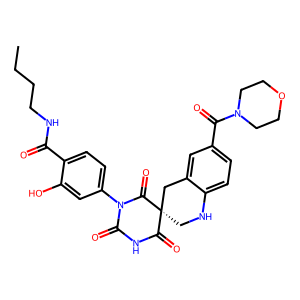

In [8]:
df.mol = df.mol.apply(uru.get_largest_fragment)
df.mol[0]

Instantiate a RingSystemFinder object and find ring systems for the molecules in df

In [9]:
ring_system_finder = uru.RingSystemFinder()
df['ring_sytems'] = df.mol.apply(ring_system_finder.find_ring_systems)
df.ring_sytems

0       [c1ccccc1, O=C1NC(=O)C2(CNc3ccccc3C2)C(=O)N1, ...
1       [O=C1c2cc3ccccc3nc2C(=O)c2cccnc21, C1COCCN1, c...
2       [c1ccccc1, O=C1C=CC(=O)N1, c1ccccc1, c1ccccc1,...
3       [O=C1N[N@@+]12C(=O)C1[C@H]3[C@H]4[C@@H]2[C@@H]...
4       [c1ccccc1, c1ccccc1, O=c1ccnc[nH]1, C1CCCC1, C...
                              ...                        
5601                      [c1ccc2ncccc2c1, N=c1cccc[nH]1]
5602                  [c1ccccc1, c1ccc2c(c1)OCO2, C1CNC1]
5603                          [c1ccc2c(c1)OCO2, c1ccccc1]
5604                          [c1ccccc1, c1ccc2c(c1)OCO2]
5605               [O=[N+]1OCOc2ccccc21, c1ccc2c(c1)OCO2]
Name: ring_sytems, Length: 5606, dtype: object

In [10]:
df.ring_sytems.values

array([list(['c1ccccc1', 'O=C1NC(=O)C2(CNc3ccccc3C2)C(=O)N1', 'C1COCCN1']),
       list(['O=C1c2cc3ccccc3nc2C(=O)c2cccnc21', 'C1COCCN1', 'c1ccc2nc3ccccc3cc2c1']),
       list(['c1ccccc1', 'O=C1C=CC(=O)N1', 'c1ccccc1', 'c1ccccc1', 'c1ccccc1']),
       ..., list(['c1ccc2c(c1)OCO2', 'c1ccccc1']),
       list(['c1ccccc1', 'c1ccc2c(c1)OCO2']),
       list(['O=[N+]1OCOc2ccccc21', 'c1ccc2c(c1)OCO2'])], dtype=object)

See how many times each ring system occurs

In [12]:
ring_system_list = list(itertools.chain.from_iterable(df.ring_sytems.values))
ring_count_df = pd.DataFrame(Counter(ring_system_list).items(),columns=["SMILES","Count"]) ### Convert a dictionary to a DataFrame.
ring_count_df.sort_values("Count",ascending=False,inplace=True)
ring_count_df

SMILES  Count
0                                              c1ccccc1   3550
135                                             C1CCOC1    321
30                                             c1ccncc1    283
130                                               C1CO1    278
16                                              c1ccoc1    245
...                                                 ...    ...
28                  O=C1NC2C(=O)C3CCCCC3C(=O)N2C2NCNC12      1
2336                               C1CN[C@H]2CN[C@H]2C1      1
2337  O=C1c2ccccc2COc2ccc(cc2)CNS(=O)(=O)c2ccc3c(c2)N13      1
2338                     c1ccc2c(c1)[C@@H]1CCC[C@H]2CC1      1
2339                                     O=C1NNC2SCCC12      1

[2379 rows x 2 columns]

View the ring system frequencies

In [13]:
mols2grid.display(ring_count_df,subset=["img","Count"])

MolGridWidget()

The RingSystemLookup object has a dictionary of how many times each ring system occurs in the ChEMBL database.  We can use this object to evaluate the molecules in df.

In [15]:
ring_system_lookup = uru.RingSystemLookup()
res = df.mol.apply(ring_system_lookup.process_mol)

[14:36:14] unrecognized chirality tag (7) on atom 8 is ignored.


In [16]:
res

0       [(c1ccccc1, 2568039), (O=C1NC(=O)C2(CNc3ccccc3...
1       [(O=C1c2cc3ccccc3nc2C(=O)c2cccnc21, 7), (C1COC...
2       [(c1ccccc1, 2568039), (O=C1C=CC(=O)N1, 2678), ...
3       [(O=C1N[N@@+]12C(=O)C1[C@H]3[C@H]4[C@@H]2[C@@H...
4       [(c1ccccc1, 2568039), (c1ccccc1, 2568039), (O=...
                              ...                        
5601      [(c1ccc2ncccc2c1, 65247), (N=c1cccc[nH]1, 151)]
5602    [(c1ccccc1, 2568039), (c1ccc2c(c1)OCO2, 26879)...
5603      [(c1ccc2c(c1)OCO2, 26879), (c1ccccc1, 2568039)]
5604      [(c1ccccc1, 2568039), (c1ccc2c(c1)OCO2, 26879)]
5605    [(O=[N+]1OCOc2ccccc21, 0), (c1ccc2c(c1)OCO2, 2...
Name: mol, Length: 5606, dtype: object

In [17]:
df[['min_ring','min_freq']] = res.apply(uru.get_min_ring_frequency).tolist()
df

SMILES  \
0     CCCCNC(=O)c1ccc(N2C(=O)NC(=O)[C@@]3(CNc4ccc(C(...   
1     O=C1c2cc3cc(C(=O)N4CCOCC4)ccc3nc2C(=O)c2ccc(-c...   
2     O=CN(C(=O)c1cccc(N2C(=O)C=C(c3ccc(C(=O)NC(=O)c...   
3     CCCN1C(=O)[N@+]12C(=O)C1[C@H]3[C@H]4[C@@H]2[C@...   
4     COc1cc(NC(=O)Nc2cc(-n3cnc(C(=O)NC4CCCC4)cc3=O)...   
...                                                 ...   
5601  CCCNC(=O)c1cc(C(=O)N=c2ccc(C)c[nH]2)c2cc(O)ccc2n1   
5602  O=C(N[C@H](c1ccc([N+](=O)O)cc1)c1ccc2c(c1)OCO2...   
5603  CCCNNC(=O)N(c1ccc2c(c1)OCO2)c1ccc(Cl)c([N+](=O...   
5604  Cc1cc(NC#N)c([C@@H](O)c2ccc3c(c2)OCO3)cc1[N+](...   
5605  N#CNC(=O)N(C[C@H]1Oc2ccccc2[N+](=O)O1)c1ccc2c(...   

                                                   mol  \
0     <rdkit.Chem.rdchem.Mol object at 0x733fa8c50820>   
1     <rdkit.Chem.rdchem.Mol object at 0x733fa8c529d0>   
2     <rdkit.Chem.rdchem.Mol object at 0x733fa8c082e0>   
3     <rdkit.Chem.rdchem.Mol object at 0x733fa8c08350>   
4     <rdkit.Chem.rdchem.Mol object at 0x733fa8c083c0>   
...                                                ...   
5601  <rdkit.Chem.rdchem.Mol object at 0x733fa8b06960>   
5602  <rdkit.Chem.rdchem.Mol object at 0x733fa8b069d0>   
5603  <rdkit.Chem.rdchem.Mol object at 0x733fa8b06a40>   
5604  <rdkit.Chem.rdchem.Mol object at 0x733fa8b06ab0>   
5605  <rdkit.Chem.rdchem.Mol object at 0x733fa8b06b20>   

                                            ring_sytems  \
0     [c1ccccc1, O=C1NC(=O)C2(CNc3ccccc3C2)C(=O)N1, ...   
1     [O=C1c2cc3ccccc3nc2C(=O)c2cccnc21, C1COCCN1, c...   
2     [c1ccccc1, O=C1C=CC(=O)N1, c1ccccc1, c1ccccc1,...   
3     [O=C1N[N@@+]12C(=O)C1[C@H]3[C@H]4[C@@H]2[C@@H]...   
4     [c1ccccc1, c1ccccc1, O=c1ccnc[nH]1, C1CCCC1, C...   
...                                                 ...   
5601                    [c1ccc2ncccc2c1, N=c1cccc[nH]1]   
5602                [c1ccccc1, c1ccc2c(c1)OCO2, C1CNC1]   
5603                        [c1ccc2c(c1)OCO2, c1ccccc1]   
5604                        [c1ccccc1, c1ccc2c(c1)OCO2]   
5605             [O=[N+]1OCOc2ccccc21, c1ccc2c(c1)OCO2]   

                                               min_ring min_freq  
0                     O=C1NC(=O)C2(CNc3ccccc3C2)C(=O)N1       27  
1                      O=C1c2cc3ccccc3nc2C(=O)c2cccnc21        7  
2                                        O=C1C=CC(=O)N1     2678  
3     O=C1N[N@@+]12C(=O)C1[C@H]3[C@H]4[C@@H]2[C@@H]2...        0  
4                                         O=c1ccnc[nH]1     7092  
...                                                 ...      ...  
5601                                      N=c1cccc[nH]1      151  
5602                                             C1CNC1    17576  
5603                                    c1ccc2c(c1)OCO2    26879  
5604                                    c1ccc2c(c1)OCO2    26879  
5605                                O=[N+]1OCOc2ccccc21        0  

[5606 rows x 5 columns]

In [18]:
df_ring_appearance_0 = df[df['min_freq'] == 0]
df_ring_appearance_0

SMILES  \
3     CCCN1C(=O)[N@+]12C(=O)C1[C@H]3[C@H]4[C@@H]2[C@...   
5     CCn1c(O)c2cc3c(cc2c1O)C(O)N1C[C@H](Oc2ccc(C(=O...   
6     O=C(c1ccc(Oc2cc(O)n(CC3CCC4C(=O)N(c5ccccc5)N[C...   
8     CC(=O)N1C=C(C=Cc2nc(O)cn(-c3ccc(C(=O)NCc4ccco4...   
10    O=c1[nH]c2cc3c(O)n(-c4ccccc4)c(=O)n3cc2c(O)c1N...   
...                                                 ...   
5572  N#CC(=O)N[C@@H]1c2cc3c(cc2O[C@H]1CNS(=O)(=O)c1...   
5582  C=CCN=C1SC([C@](N)(O)[C@@H](C#N)c2ccc3c(c2)OCO...   
5584  CCO[C@H]1C[C@H](OC2NNNN2)[C@@H](c2cccc(O)c2)C[...   
5600  Cc1cc(=O)n2c(n1)NS(=O)(=O)c1ccc(S(=O)(=O)Nc3cc...   
5605  N#CNC(=O)N(C[C@H]1Oc2ccccc2[N+](=O)O1)c1ccc2c(...   

                                                   mol  \
3     <rdkit.Chem.rdchem.Mol object at 0x733fa8c08350>   
5     <rdkit.Chem.rdchem.Mol object at 0x733fa8c08430>   
6     <rdkit.Chem.rdchem.Mol object at 0x733fa8c084a0>   
8     <rdkit.Chem.rdchem.Mol object at 0x733fa8c08580>   
10    <rdkit.Chem.rdchem.Mol object at 0x733fa8c08660>   
...                                                ...   
5572  <rdkit.Chem.rdchem.Mol object at 0x733fa8b05cb0>   
5582  <rdkit.Chem.rdchem.Mol object at 0x733fa8b06110>   
5584  <rdkit.Chem.rdchem.Mol object at 0x733fa8b061f0>   
5600  <rdkit.Chem.rdchem.Mol object at 0x733fa8b068f0>   
5605  <rdkit.Chem.rdchem.Mol object at 0x733fa8b06b20>   

                                            ring_sytems  \
3     [O=C1N[N@@+]12C(=O)C1[C@H]3[C@H]4[C@@H]2[C@@H]...   
5     [c1[nH]cc2cc3c(cc12)CC1CCCCN1C3, c1ccccc1, C1C...   
6     [c1ccccc1, c1cc[nH]c1, O=C1NN[C@@H]2CCCCC12, c...   
8     [C1=CNc2ccccc2C=C1, O=c1cncc[nH]1, c1ccccc1, c...   
10    [O=c1ccc2cn3c(=O)[nH]cc3cc2[nH]1, c1ccccc1, c1...   
...                                                 ...   
5572                   [c1c2c(cc3c1OCO3)OCC2, c1ccccc1]   
5582                [N=C1SCCC1=[NH2+], c1ccc2c(c1)OCO2]   
5584             [O=[N+]1OC12CCCCC2, C1NNNN1, c1ccccc1]   
5600        [O=c1ccnc2n1-c1ccccc1S(=O)(=O)N2, c1ccccc1]   
5605             [O=[N+]1OCOc2ccccc21, c1ccc2c(c1)OCO2]   

                                               min_ring min_freq  
3     O=C1N[N@@+]12C(=O)C1[C@H]3[C@H]4[C@@H]2[C@@H]2...        0  
5                        c1[nH]cc2cc3c(cc12)CC1CCCCN1C3        0  
6                                  O=C1NN[C@@H]2CCCCC12        0  
8                                     C1=CNc2ccccc2C=C1        0  
10                      O=c1ccc2cn3c(=O)[nH]cc3cc2[nH]1        0  
...                                                 ...      ...  
5572                               c1c2c(cc3c1OCO3)OCC2        0  
5582                                   N=C1SCCC1=[NH2+]        0  
5584                                  O=[N+]1OC12CCCCC2        0  
5600                    O=c1ccnc2n1-c1ccccc1S(=O)(=O)N2        0  
5605                                O=[N+]1OCOc2ccccc21        0  

[2084 rows x 5 columns]

In [19]:
df_ring_appearance_0['SMILES'].to_csv('smi_list_molsnapper_testset_appearance_0.smi',index=False,header=False)

In [20]:
mols2grid.display(df.sort_values("min_freq"),mol_col="mol",subset=["img","min_freq"])

MolGridWidget()

### Check how many molecules are unique the ring frequency of them

How many molecules are unique using inChI?

In [21]:
df['inchi'] = df.mol.apply(Chem.MolToInchi)
df = df.drop_duplicates("inchi", keep="first", ignore_index=True)
df

[14:36:40] WARNING: Proton(s) added/removed

[14:36:40] WARNING: Proton(s) added/removed

[14:36:40] WARNING: Omitted undefined stereo

[14:36:40] WARNING: Omitted undefined stereo

[14:36:40] WARNING: Omitted undefined stereo

[14:36:40] WARNING: Proton(s) added/removed

[14:36:40] WARNING: Omitted undefined stereo

[14:36:40] WARNING: Proton(s) added/removed; Omitted undefined stereo

[14:36:40] WARNING: Omitted undefined stereo

[14:36:40] WARNING: Omitted undefined stereo

[14:36:40] WARNING: Proton(s) added/removed

[14:36:40] WARNING: Omitted undefined stereo

[14:36:40] WARNING: Proton(s) added/removed; Omitted undefined stereo

[14:36:40] WARNING: Omitted undefined stereo

[14:36:40] WARNING: Omitted undefined stereo

[14:36:40] WARNING: Proton(s) added/removed

[14:36:40] WARNING: Omitted undefined stereo

[14:36:40] WARNING: Omitted undefined stereo

[14:36:40] WARNING: Omitted undefined stereo

[14:36:40] WARNING: Proton(s) added/removed

[14:36:40] WARNING: Omitted undefine

SMILES  \
0     CCCCNC(=O)c1ccc(N2C(=O)NC(=O)[C@@]3(CNc4ccc(C(...   
1     O=C1c2cc3cc(C(=O)N4CCOCC4)ccc3nc2C(=O)c2ccc(-c...   
2     O=CN(C(=O)c1cccc(N2C(=O)C=C(c3ccc(C(=O)NC(=O)c...   
3     CCCN1C(=O)[N@+]12C(=O)C1[C@H]3[C@H]4[C@@H]2[C@...   
4     COc1cc(NC(=O)Nc2cc(-n3cnc(C(=O)NC4CCCC4)cc3=O)...   
...                                                 ...   
5584  CCCNC(=O)c1cc(C(=O)N=c2ccc(C)c[nH]2)c2cc(O)ccc2n1   
5585  O=C(N[C@H](c1ccc([N+](=O)O)cc1)c1ccc2c(c1)OCO2...   
5586  CCCNNC(=O)N(c1ccc2c(c1)OCO2)c1ccc(Cl)c([N+](=O...   
5587  Cc1cc(NC#N)c([C@@H](O)c2ccc3c(c2)OCO3)cc1[N+](...   
5588  N#CNC(=O)N(C[C@H]1Oc2ccccc2[N+](=O)O1)c1ccc2c(...   

                                                   mol  \
0     <rdkit.Chem.rdchem.Mol object at 0x733fa8c50820>   
1     <rdkit.Chem.rdchem.Mol object at 0x733fa8c529d0>   
2     <rdkit.Chem.rdchem.Mol object at 0x733fa8c082e0>   
3     <rdkit.Chem.rdchem.Mol object at 0x733fa8c08350>   
4     <rdkit.Chem.rdchem.Mol object at 0x733fa8c083c0>   
...                                                ...   
5584  <rdkit.Chem.rdchem.Mol object at 0x733fa8b06960>   
5585  <rdkit.Chem.rdchem.Mol object at 0x733fa8b069d0>   
5586  <rdkit.Chem.rdchem.Mol object at 0x733fa8b06a40>   
5587  <rdkit.Chem.rdchem.Mol object at 0x733fa8b06ab0>   
5588  <rdkit.Chem.rdchem.Mol object at 0x733fa8b06b20>   

                                            ring_sytems  \
0     [c1ccccc1, O=C1NC(=O)C2(CNc3ccccc3C2)C(=O)N1, ...   
1     [O=C1c2cc3ccccc3nc2C(=O)c2cccnc21, C1COCCN1, c...   
2     [c1ccccc1, O=C1C=CC(=O)N1, c1ccccc1, c1ccccc1,...   
3     [O=C1N[N@@+]12C(=O)C1[C@H]3[C@H]4[C@@H]2[C@@H]...   
4     [c1ccccc1, c1ccccc1, O=c1ccnc[nH]1, C1CCCC1, C...   
...                                                 ...   
5584                    [c1ccc2ncccc2c1, N=c1cccc[nH]1]   
5585                [c1ccccc1, c1ccc2c(c1)OCO2, C1CNC1]   
5586                        [c1ccc2c(c1)OCO2, c1ccccc1]   
5587                        [c1ccccc1, c1ccc2c(c1)OCO2]   
5588             [O=[N+]1OCOc2ccccc21, c1ccc2c(c1)OCO2]   

                                               min_ring min_freq  \
0                     O=C1NC(=O)C2(CNc3ccccc3C2)C(=O)N1       27   
1                      O=C1c2cc3ccccc3nc2C(=O)c2cccnc21        7   
2                                        O=C1C=CC(=O)N1     2678   
3     O=C1N[N@@+]12C(=O)C1[C@H]3[C@H]4[C@@H]2[C@@H]2...        0   
4                                         O=c1ccnc[nH]1     7092   
...                                                 ...      ...   
5584                                      N=c1cccc[nH]1      151   
5585                                             C1CNC1    17576   
5586                                    c1ccc2c(c1)OCO2    26879   
5587                                    c1ccc2c(c1)OCO2    26879   
5588                                O=[N+]1OCOc2ccccc21        0   

                                                  inchi  
0     InChI=1S/C28H31N5O7/c1-2-3-8-29-23(35)20-6-5-1...  
1     InChI=1S/C34H22N4O4/c39-32-24-7-10-27(20-5-8-2...  
2     InChI=1S/C32H21N3O6/c36-20-34(25-11-5-2-6-12-2...  
3     InChI=1S/C31H31N3O6/c1-3-8-32-29(38)34(32)24-2...  
4     InChI=1S/C28H31N7O7/c1-41-25-14-19(6-8-24(25)3...  
...                                                 ...  
5584  InChI=1S/C20H20N4O3/c1-3-8-21-20(27)17-10-15(1...  
5585  InChI=1S/C18H17N3O5/c22-18(14-7-8-19-14)20-17(...  
5586  InChI=1S/C17H17ClN4O5/c1-2-7-19-20-17(23)21(11...  
5587  InChI=1S/C16H14N3O5/c1-9-4-12(18-7-17)11(6-13(...  
5588  InChI=1S/C17H12N4O6/c18-9-19-17(22)20(11-5-6-1...  

[5589 rows x 6 columns]

Check how many molecules have ring system?

In [22]:
df_ring = df[df.min_freq != -1]
df_ring

SMILES  \
0     CCCCNC(=O)c1ccc(N2C(=O)NC(=O)[C@@]3(CNc4ccc(C(...   
1     O=C1c2cc3cc(C(=O)N4CCOCC4)ccc3nc2C(=O)c2ccc(-c...   
2     O=CN(C(=O)c1cccc(N2C(=O)C=C(c3ccc(C(=O)NC(=O)c...   
3     CCCN1C(=O)[N@+]12C(=O)C1[C@H]3[C@H]4[C@@H]2[C@...   
4     COc1cc(NC(=O)Nc2cc(-n3cnc(C(=O)NC4CCCC4)cc3=O)...   
...                                                 ...   
5584  CCCNC(=O)c1cc(C(=O)N=c2ccc(C)c[nH]2)c2cc(O)ccc2n1   
5585  O=C(N[C@H](c1ccc([N+](=O)O)cc1)c1ccc2c(c1)OCO2...   
5586  CCCNNC(=O)N(c1ccc2c(c1)OCO2)c1ccc(Cl)c([N+](=O...   
5587  Cc1cc(NC#N)c([C@@H](O)c2ccc3c(c2)OCO3)cc1[N+](...   
5588  N#CNC(=O)N(C[C@H]1Oc2ccccc2[N+](=O)O1)c1ccc2c(...   

                                                   mol  \
0     <rdkit.Chem.rdchem.Mol object at 0x733fa8c50820>   
1     <rdkit.Chem.rdchem.Mol object at 0x733fa8c529d0>   
2     <rdkit.Chem.rdchem.Mol object at 0x733fa8c082e0>   
3     <rdkit.Chem.rdchem.Mol object at 0x733fa8c08350>   
4     <rdkit.Chem.rdchem.Mol object at 0x733fa8c083c0>   
...                                                ...   
5584  <rdkit.Chem.rdchem.Mol object at 0x733fa8b06960>   
5585  <rdkit.Chem.rdchem.Mol object at 0x733fa8b069d0>   
5586  <rdkit.Chem.rdchem.Mol object at 0x733fa8b06a40>   
5587  <rdkit.Chem.rdchem.Mol object at 0x733fa8b06ab0>   
5588  <rdkit.Chem.rdchem.Mol object at 0x733fa8b06b20>   

                                            ring_sytems  \
0     [c1ccccc1, O=C1NC(=O)C2(CNc3ccccc3C2)C(=O)N1, ...   
1     [O=C1c2cc3ccccc3nc2C(=O)c2cccnc21, C1COCCN1, c...   
2     [c1ccccc1, O=C1C=CC(=O)N1, c1ccccc1, c1ccccc1,...   
3     [O=C1N[N@@+]12C(=O)C1[C@H]3[C@H]4[C@@H]2[C@@H]...   
4     [c1ccccc1, c1ccccc1, O=c1ccnc[nH]1, C1CCCC1, C...   
...                                                 ...   
5584                    [c1ccc2ncccc2c1, N=c1cccc[nH]1]   
5585                [c1ccccc1, c1ccc2c(c1)OCO2, C1CNC1]   
5586                        [c1ccc2c(c1)OCO2, c1ccccc1]   
5587                        [c1ccccc1, c1ccc2c(c1)OCO2]   
5588             [O=[N+]1OCOc2ccccc21, c1ccc2c(c1)OCO2]   

                                               min_ring min_freq  \
0                     O=C1NC(=O)C2(CNc3ccccc3C2)C(=O)N1       27   
1                      O=C1c2cc3ccccc3nc2C(=O)c2cccnc21        7   
2                                        O=C1C=CC(=O)N1     2678   
3     O=C1N[N@@+]12C(=O)C1[C@H]3[C@H]4[C@@H]2[C@@H]2...        0   
4                                         O=c1ccnc[nH]1     7092   
...                                                 ...      ...   
5584                                      N=c1cccc[nH]1      151   
5585                                             C1CNC1    17576   
5586                                    c1ccc2c(c1)OCO2    26879   
5587                                    c1ccc2c(c1)OCO2    26879   
5588                                O=[N+]1OCOc2ccccc21        0   

                                                  inchi  
0     InChI=1S/C28H31N5O7/c1-2-3-8-29-23(35)20-6-5-1...  
1     InChI=1S/C34H22N4O4/c39-32-24-7-10-27(20-5-8-2...  
2     InChI=1S/C32H21N3O6/c36-20-34(25-11-5-2-6-12-2...  
3     InChI=1S/C31H31N3O6/c1-3-8-32-29(38)34(32)24-2...  
4     InChI=1S/C28H31N7O7/c1-41-25-14-19(6-8-24(25)3...  
...                                                 ...  
5584  InChI=1S/C20H20N4O3/c1-3-8-21-20(27)17-10-15(1...  
5585  InChI=1S/C18H17N3O5/c22-18(14-7-8-19-14)20-17(...  
5586  InChI=1S/C17H17ClN4O5/c1-2-7-19-20-17(23)21(11...  
5587  InChI=1S/C16H14N3O5/c1-9-4-12(18-7-17)11(6-13(...  
5588  InChI=1S/C17H12N4O6/c18-9-19-17(22)20(11-5-6-1...  

[5302 rows x 6 columns]

In [23]:
filtered_df_ring_freq = df[df.min_freq > 100]
filtered_df_ring_freq

SMILES  \
2     O=CN(C(=O)c1cccc(N2C(=O)C=C(c3ccc(C(=O)NC(=O)c...   
4     COc1cc(NC(=O)Nc2cc(-n3cnc(C(=O)NC4CCCC4)cc3=O)...   
7     O=Cn1c(-c2ccccc2)nc2cc(C(=O)NC(=O)C(=O)Nc3ccc(...   
9     Cc1ccc(NC(=O)c2ccc(C(=O)OCC(=O)Nc3ccc(-n4c(=O)...   
12    Cc1cc(C(=O)Nc2ccccc2)c(O)c2cc(C(=O)Nc3ccc4c(c3...   
...                                                 ...   
5582  NC(=O)C(=NC(=O)CCc1ccccc1[N+](=O)O)c1cccc([N+]...   
5584  CCCNC(=O)c1cc(C(=O)N=c2ccc(C)c[nH]2)c2cc(O)ccc2n1   
5585  O=C(N[C@H](c1ccc([N+](=O)O)cc1)c1ccc2c(c1)OCO2...   
5586  CCCNNC(=O)N(c1ccc2c(c1)OCO2)c1ccc(Cl)c([N+](=O...   
5587  Cc1cc(NC#N)c([C@@H](O)c2ccc3c(c2)OCO3)cc1[N+](...   

                                                   mol  \
2     <rdkit.Chem.rdchem.Mol object at 0x733fa8c082e0>   
4     <rdkit.Chem.rdchem.Mol object at 0x733fa8c083c0>   
7     <rdkit.Chem.rdchem.Mol object at 0x733fa8c08510>   
9     <rdkit.Chem.rdchem.Mol object at 0x733fa8c085f0>   
12    <rdkit.Chem.rdchem.Mol object at 0x733fa8c08740>   
...                                                ...   
5582  <rdkit.Chem.rdchem.Mol object at 0x733fa8b06880>   
5584  <rdkit.Chem.rdchem.Mol object at 0x733fa8b06960>   
5585  <rdkit.Chem.rdchem.Mol object at 0x733fa8b069d0>   
5586  <rdkit.Chem.rdchem.Mol object at 0x733fa8b06a40>   
5587  <rdkit.Chem.rdchem.Mol object at 0x733fa8b06ab0>   

                                            ring_sytems  \
2     [c1ccccc1, O=C1C=CC(=O)N1, c1ccccc1, c1ccccc1,...   
4     [c1ccccc1, c1ccccc1, O=c1ccnc[nH]1, C1CCCC1, C...   
7      [c1ccc2[nH]cnc2c1, c1ccccc1, c1ccccc1, c1ccccc1]   
9     [c1ccccc1, c1ccccc1, c1ccccc1, O=c1[nH]c(=O)c2...   
12    [O=c1ccc2ccccc2o1, c1ccccc1, O=C1NC(=O)c2ccccc...   
...                                                 ...   
5582                               [c1ccccc1, c1ccccc1]   
5584                    [c1ccc2ncccc2c1, N=c1cccc[nH]1]   
5585                [c1ccccc1, c1ccc2c(c1)OCO2, C1CNC1]   
5586                        [c1ccc2c(c1)OCO2, c1ccccc1]   
5587                        [c1ccccc1, c1ccc2c(c1)OCO2]   

                        min_ring min_freq  \
2                 O=C1C=CC(=O)N1     2678   
4                  O=c1ccnc[nH]1     7092   
7               c1ccc2[nH]cnc2c1    49899   
9     O=c1[nH]c(=O)c2ccccc2[nH]1     3081   
12           O=C1NC(=O)c2ccccc21    10649   
...                          ...      ...   
5582                    c1ccccc1  2568039   
5584               N=c1cccc[nH]1      151   
5585                      C1CNC1    17576   
5586             c1ccc2c(c1)OCO2    26879   
5587             c1ccc2c(c1)OCO2    26879   

                                                  inchi  
2     InChI=1S/C32H21N3O6/c36-20-34(25-11-5-2-6-12-2...  
4     InChI=1S/C28H31N7O7/c1-41-25-14-19(6-8-24(25)3...  
7     InChI=1S/C29H20N6O5/c36-17-35-24-14-11-19(15-2...  
9     InChI=1S/C31H24N4O6/c1-19-6-12-23(13-7-19)33-2...  
12    InChI=1S/C32H21N3O7/c1-17-14-24(28(37)33-18-8-...  
...                                                 ...  
5582  InChI=1S/C17H15N4O6/c18-17(23)16(12-5-3-6-13(1...  
5584  InChI=1S/C20H20N4O3/c1-3-8-21-20(27)17-10-15(1...  
5585  InChI=1S/C18H17N3O5/c22-18(14-7-8-19-14)20-17(...  
5586  InChI=1S/C17H17ClN4O5/c1-2-7-19-20-17(23)21(11...  
5587  InChI=1S/C16H14N3O5/c1-9-4-12(18-7-17)11(6-13(...  

[2603 rows x 6 columns]

### How many of them could pass PAINS filter?

Get a list of rules

In [24]:
reos = uru.REOS()
reos.get_available_rule_sets()

array(['Glaxo', 'Dundee', 'BMS', 'PAINS', 'SureChEMBL', 'MLSMR',
       'Inpharmatica', 'LINT'], dtype=object)

Get the currently active rule sets

In [25]:
reos.get_active_rule_sets()

array(['Glaxo'], dtype=object)

Set active rule set to PAINS

In [26]:
reos.set_active_rule_sets(['PAINS'])
reos.get_active_rule_sets()

array(['PAINS'], dtype=object)

Apply PAINS filter to unique mols

In [27]:
reos.pandas_mols(df.mol)

  0%|          | 0/5589 [00:00<?, ?it/s]

rule_set_name     description
0               ok              ok
1            PAINS  quinone_A(370)
2               ok              ok
3               ok              ok
4               ok              ok
...            ...             ...
5584            ok              ok
5585            ok              ok
5586            ok              ok
5587            ok              ok
5588            ok              ok

[5589 rows x 2 columns]

In [28]:
df_PAINS_filter = pd.concat([df, reos.pandas_mols(df.mol)], axis=1)
df_PAINS_filter = df_PAINS_filter[df_PAINS_filter.description == 'ok']
df_PAINS_filter

  0%|          | 0/5589 [00:00<?, ?it/s]

SMILES  \
0     CCCCNC(=O)c1ccc(N2C(=O)NC(=O)[C@@]3(CNc4ccc(C(...   
2     O=CN(C(=O)c1cccc(N2C(=O)C=C(c3ccc(C(=O)NC(=O)c...   
3     CCCN1C(=O)[N@+]12C(=O)C1[C@H]3[C@H]4[C@@H]2[C@...   
4     COc1cc(NC(=O)Nc2cc(-n3cnc(C(=O)NC4CCCC4)cc3=O)...   
5     CCn1c(O)c2cc3c(cc2c1O)C(O)N1C[C@H](Oc2ccc(C(=O...   
...                                                 ...   
5584  CCCNC(=O)c1cc(C(=O)N=c2ccc(C)c[nH]2)c2cc(O)ccc2n1   
5585  O=C(N[C@H](c1ccc([N+](=O)O)cc1)c1ccc2c(c1)OCO2...   
5586  CCCNNC(=O)N(c1ccc2c(c1)OCO2)c1ccc(Cl)c([N+](=O...   
5587  Cc1cc(NC#N)c([C@@H](O)c2ccc3c(c2)OCO3)cc1[N+](...   
5588  N#CNC(=O)N(C[C@H]1Oc2ccccc2[N+](=O)O1)c1ccc2c(...   

                                                   mol  \
0     <rdkit.Chem.rdchem.Mol object at 0x733fa8c50820>   
2     <rdkit.Chem.rdchem.Mol object at 0x733fa8c082e0>   
3     <rdkit.Chem.rdchem.Mol object at 0x733fa8c08350>   
4     <rdkit.Chem.rdchem.Mol object at 0x733fa8c083c0>   
5     <rdkit.Chem.rdchem.Mol object at 0x733fa8c08430>   
...                                                ...   
5584  <rdkit.Chem.rdchem.Mol object at 0x733fa8b06960>   
5585  <rdkit.Chem.rdchem.Mol object at 0x733fa8b069d0>   
5586  <rdkit.Chem.rdchem.Mol object at 0x733fa8b06a40>   
5587  <rdkit.Chem.rdchem.Mol object at 0x733fa8b06ab0>   
5588  <rdkit.Chem.rdchem.Mol object at 0x733fa8b06b20>   

                                            ring_sytems  \
0     [c1ccccc1, O=C1NC(=O)C2(CNc3ccccc3C2)C(=O)N1, ...   
2     [c1ccccc1, O=C1C=CC(=O)N1, c1ccccc1, c1ccccc1,...   
3     [O=C1N[N@@+]12C(=O)C1[C@H]3[C@H]4[C@@H]2[C@@H]...   
4     [c1ccccc1, c1ccccc1, O=c1ccnc[nH]1, C1CCCC1, C...   
5     [c1[nH]cc2cc3c(cc12)CC1CCCCN1C3, c1ccccc1, C1C...   
...                                                 ...   
5584                    [c1ccc2ncccc2c1, N=c1cccc[nH]1]   
5585                [c1ccccc1, c1ccc2c(c1)OCO2, C1CNC1]   
5586                        [c1ccc2c(c1)OCO2, c1ccccc1]   
5587                        [c1ccccc1, c1ccc2c(c1)OCO2]   
5588             [O=[N+]1OCOc2ccccc21, c1ccc2c(c1)OCO2]   

                                               min_ring min_freq  \
0                     O=C1NC(=O)C2(CNc3ccccc3C2)C(=O)N1       27   
2                                        O=C1C=CC(=O)N1     2678   
3     O=C1N[N@@+]12C(=O)C1[C@H]3[C@H]4[C@@H]2[C@@H]2...        0   
4                                         O=c1ccnc[nH]1     7092   
5                        c1[nH]cc2cc3c(cc12)CC1CCCCN1C3        0   
...                                                 ...      ...   
5584                                      N=c1cccc[nH]1      151   
5585                                             C1CNC1    17576   
5586                                    c1ccc2c(c1)OCO2    26879   
5587                                    c1ccc2c(c1)OCO2    26879   
5588                                O=[N+]1OCOc2ccccc21        0   

                                                  inchi rule_set_name  \
0     InChI=1S/C28H31N5O7/c1-2-3-8-29-23(35)20-6-5-1...            ok   
2     InChI=1S/C32H21N3O6/c36-20-34(25-11-5-2-6-12-2...            ok   
3     InChI=1S/C31H31N3O6/c1-3-8-32-29(38)34(32)24-2...            ok   
4     InChI=1S/C28H31N7O7/c1-41-25-14-19(6-8-24(25)3...            ok   
5     InChI=1S/C28H33N3O9/c1-2-30-26(36)18-11-16-17(...            ok   
...                                                 ...           ...   
5584  InChI=1S/C20H20N4O3/c1-3-8-21-20(27)17-10-15(1...            ok   
5585  InChI=1S/C18H17N3O5/c22-18(14-7-8-19-14)20-17(...            ok   
5586  InChI=1S/C17H17ClN4O5/c1-2-7-19-20-17(23)21(11...            ok   
5587  InChI=1S/C16H14N3O5/c1-9-4-12(18-7-17)11(6-13(...            ok   
5588  InChI=1S/C17H12N4O6/c18-9-19-17(22)20(11-5-6-1...            ok   

     description  
0             ok  
2             ok  
3             ok  
4             ok  
5             ok  
...          ...  
5584          ok  
5585          ok  
5586          ok  
5587          ok  
5588          ok  

[5302 rows 

test all filters from rd filter

In [29]:
rd_filters = ['Glaxo', 'Dundee', 'BMS', 'SureChEMBL', 'MLSMR', 'Inpharmatica', 'LINT']
for filter in rd_filters:
    reos.set_active_rule_sets([filter])
    new_df = reos.pandas_mols(df.mol)
    print(filter, len(new_df[new_df.description == "ok"])/len(new_df), reos.get_active_rule_sets(), len(new_df[new_df.description == "ok"]))

  0%|          | 0/5589 [00:00<?, ?it/s]

Glaxo 0.694757559491859 ['Glaxo'] 3883


  0%|          | 0/5589 [00:00<?, ?it/s]

Dundee 0.18106995884773663 ['Dundee'] 1012


  0%|          | 0/5589 [00:00<?, ?it/s]

BMS 0.5151189837180176 ['BMS'] 2879


  0%|          | 0/5589 [00:00<?, ?it/s]

SureChEMBL 0.41205940239756667 ['SureChEMBL'] 2303


  0%|          | 0/5589 [00:00<?, ?it/s]

MLSMR 0.24870280908928252 ['MLSMR'] 1390


  0%|          | 0/5589 [00:00<?, ?it/s]

Inpharmatica 0.39416711397387727 ['Inpharmatica'] 2203


  0%|          | 0/5589 [00:00<?, ?it/s]

LINT 0.330470567185543 ['LINT'] 1847


### How many of them could pass filters suggested by Dr.Reymond?

In [30]:
df['Reymond'] = df.mol.apply(filter_molecules)
df

SMILES  \
0     CCCCNC(=O)c1ccc(N2C(=O)NC(=O)[C@@]3(CNc4ccc(C(...   
1     O=C1c2cc3cc(C(=O)N4CCOCC4)ccc3nc2C(=O)c2ccc(-c...   
2     O=CN(C(=O)c1cccc(N2C(=O)C=C(c3ccc(C(=O)NC(=O)c...   
3     CCCN1C(=O)[N@+]12C(=O)C1[C@H]3[C@H]4[C@@H]2[C@...   
4     COc1cc(NC(=O)Nc2cc(-n3cnc(C(=O)NC4CCCC4)cc3=O)...   
...                                                 ...   
5584  CCCNC(=O)c1cc(C(=O)N=c2ccc(C)c[nH]2)c2cc(O)ccc2n1   
5585  O=C(N[C@H](c1ccc([N+](=O)O)cc1)c1ccc2c(c1)OCO2...   
5586  CCCNNC(=O)N(c1ccc2c(c1)OCO2)c1ccc(Cl)c([N+](=O...   
5587  Cc1cc(NC#N)c([C@@H](O)c2ccc3c(c2)OCO3)cc1[N+](...   
5588  N#CNC(=O)N(C[C@H]1Oc2ccccc2[N+](=O)O1)c1ccc2c(...   

                                                   mol  \
0     <rdkit.Chem.rdchem.Mol object at 0x733fa8c50820>   
1     <rdkit.Chem.rdchem.Mol object at 0x733fa8c529d0>   
2     <rdkit.Chem.rdchem.Mol object at 0x733fa8c082e0>   
3     <rdkit.Chem.rdchem.Mol object at 0x733fa8c08350>   
4     <rdkit.Chem.rdchem.Mol object at 0x733fa8c083c0>   
...                                                ...   
5584  <rdkit.Chem.rdchem.Mol object at 0x733fa8b06960>   
5585  <rdkit.Chem.rdchem.Mol object at 0x733fa8b069d0>   
5586  <rdkit.Chem.rdchem.Mol object at 0x733fa8b06a40>   
5587  <rdkit.Chem.rdchem.Mol object at 0x733fa8b06ab0>   
5588  <rdkit.Chem.rdchem.Mol object at 0x733fa8b06b20>   

                                            ring_sytems  \
0     [c1ccccc1, O=C1NC(=O)C2(CNc3ccccc3C2)C(=O)N1, ...   
1     [O=C1c2cc3ccccc3nc2C(=O)c2cccnc21, C1COCCN1, c...   
2     [c1ccccc1, O=C1C=CC(=O)N1, c1ccccc1, c1ccccc1,...   
3     [O=C1N[N@@+]12C(=O)C1[C@H]3[C@H]4[C@@H]2[C@@H]...   
4     [c1ccccc1, c1ccccc1, O=c1ccnc[nH]1, C1CCCC1, C...   
...                                                 ...   
5584                    [c1ccc2ncccc2c1, N=c1cccc[nH]1]   
5585                [c1ccccc1, c1ccc2c(c1)OCO2, C1CNC1]   
5586                        [c1ccc2c(c1)OCO2, c1ccccc1]   
5587                        [c1ccccc1, c1ccc2c(c1)OCO2]   
5588             [O=[N+]1OCOc2ccccc21, c1ccc2c(c1)OCO2]   

                                               min_ring min_freq  \
0                     O=C1NC(=O)C2(CNc3ccccc3C2)C(=O)N1       27   
1                      O=C1c2cc3ccccc3nc2C(=O)c2cccnc21        7   
2                                        O=C1C=CC(=O)N1     2678   
3     O=C1N[N@@+]12C(=O)C1[C@H]3[C@H]4[C@@H]2[C@@H]2...        0   
4                                         O=c1ccnc[nH]1     7092   
...                                                 ...      ...   
5584                                      N=c1cccc[nH]1      151   
5585                                             C1CNC1    17576   
5586                                    c1ccc2c(c1)OCO2    26879   
5587                                    c1ccc2c(c1)OCO2    26879   
5588                                O=[N+]1OCOc2ccccc21        0   

                                                  inchi  Reymond  
0     InChI=1S/C28H31N5O7/c1-2-3-8-29-23(35)20-6-5-1...     True  
1     InChI=1S/C34H22N4O4/c39-32-24-7-10-27(20-5-8-2...     True  
2     InChI=1S/C32H21N3O6/c36-20-34(25-11-5-2-6-12-2...     True  
3     InChI=1S/C31H31N3O6/c1-3-8-32-29(38)34(32)24-2...    False  
4     InChI=1S/C28H31N7O7/c1-41-25-14-19(6-8-24(25)3...     True  
...                                                 ...      ...  
5584  InChI=1S/C20H20N4O3/c1-3-8-21-20(27)17-10-15(1...     True  
5585  InChI=1S/C18H17N3O5/c22-18(14-7-8-19-14)20-17(...     True  
5586  InChI=1S/C17H17ClN4O5/c1-2-7-19-20-17(23)21(11...     True  
5587  InChI=1S/C16H14N3O5/c1-9-4-12(18-7-17)11(6-13(...     True  
5588  InChI=1S/C17H12N4O6/c18-9-19-17(22)20(11-5-6-1...     True  

[5589 rows x 7 columns]

In [31]:
df_Reymond_filter = df[df.Reymond == True]
df_Reymond_filter

SMILES  \
0     CCCCNC(=O)c1ccc(N2C(=O)NC(=O)[C@@]3(CNc4ccc(C(...   
1     O=C1c2cc3cc(C(=O)N4CCOCC4)ccc3nc2C(=O)c2ccc(-c...   
2     O=CN(C(=O)c1cccc(N2C(=O)C=C(c3ccc(C(=O)NC(=O)c...   
4     COc1cc(NC(=O)Nc2cc(-n3cnc(C(=O)NC4CCCC4)cc3=O)...   
5     CCn1c(O)c2cc3c(cc2c1O)C(O)N1C[C@H](Oc2ccc(C(=O...   
...                                                 ...   
5584  CCCNC(=O)c1cc(C(=O)N=c2ccc(C)c[nH]2)c2cc(O)ccc2n1   
5585  O=C(N[C@H](c1ccc([N+](=O)O)cc1)c1ccc2c(c1)OCO2...   
5586  CCCNNC(=O)N(c1ccc2c(c1)OCO2)c1ccc(Cl)c([N+](=O...   
5587  Cc1cc(NC#N)c([C@@H](O)c2ccc3c(c2)OCO3)cc1[N+](...   
5588  N#CNC(=O)N(C[C@H]1Oc2ccccc2[N+](=O)O1)c1ccc2c(...   

                                                   mol  \
0     <rdkit.Chem.rdchem.Mol object at 0x733fa8c50820>   
1     <rdkit.Chem.rdchem.Mol object at 0x733fa8c529d0>   
2     <rdkit.Chem.rdchem.Mol object at 0x733fa8c082e0>   
4     <rdkit.Chem.rdchem.Mol object at 0x733fa8c083c0>   
5     <rdkit.Chem.rdchem.Mol object at 0x733fa8c08430>   
...                                                ...   
5584  <rdkit.Chem.rdchem.Mol object at 0x733fa8b06960>   
5585  <rdkit.Chem.rdchem.Mol object at 0x733fa8b069d0>   
5586  <rdkit.Chem.rdchem.Mol object at 0x733fa8b06a40>   
5587  <rdkit.Chem.rdchem.Mol object at 0x733fa8b06ab0>   
5588  <rdkit.Chem.rdchem.Mol object at 0x733fa8b06b20>   

                                            ring_sytems  \
0     [c1ccccc1, O=C1NC(=O)C2(CNc3ccccc3C2)C(=O)N1, ...   
1     [O=C1c2cc3ccccc3nc2C(=O)c2cccnc21, C1COCCN1, c...   
2     [c1ccccc1, O=C1C=CC(=O)N1, c1ccccc1, c1ccccc1,...   
4     [c1ccccc1, c1ccccc1, O=c1ccnc[nH]1, C1CCCC1, C...   
5     [c1[nH]cc2cc3c(cc12)CC1CCCCN1C3, c1ccccc1, C1C...   
...                                                 ...   
5584                    [c1ccc2ncccc2c1, N=c1cccc[nH]1]   
5585                [c1ccccc1, c1ccc2c(c1)OCO2, C1CNC1]   
5586                        [c1ccc2c(c1)OCO2, c1ccccc1]   
5587                        [c1ccccc1, c1ccc2c(c1)OCO2]   
5588             [O=[N+]1OCOc2ccccc21, c1ccc2c(c1)OCO2]   

                               min_ring min_freq  \
0     O=C1NC(=O)C2(CNc3ccccc3C2)C(=O)N1       27   
1      O=C1c2cc3ccccc3nc2C(=O)c2cccnc21        7   
2                        O=C1C=CC(=O)N1     2678   
4                         O=c1ccnc[nH]1     7092   
5        c1[nH]cc2cc3c(cc12)CC1CCCCN1C3        0   
...                                 ...      ...   
5584                      N=c1cccc[nH]1      151   
5585                             C1CNC1    17576   
5586                    c1ccc2c(c1)OCO2    26879   
5587                    c1ccc2c(c1)OCO2    26879   
5588                O=[N+]1OCOc2ccccc21        0   

                                                  inchi  Reymond  
0     InChI=1S/C28H31N5O7/c1-2-3-8-29-23(35)20-6-5-1...     True  
1     InChI=1S/C34H22N4O4/c39-32-24-7-10-27(20-5-8-2...     True  
2     InChI=1S/C32H21N3O6/c36-20-34(25-11-5-2-6-12-2...     True  
4     InChI=1S/C28H31N7O7/c1-41-25-14-19(6-8-24(25)3...     True  
5     InChI=1S/C28H33N3O9/c1-2-30-26(36)18-11-16-17(...     True  
...                                                 ...      ...  
5584  InChI=1S/C20H20N4O3/c1-3-8-21-20(27)17-10-15(1...     True  
5585  InChI=1S/C18H17N3O5/c22-18(14-7-8-19-14)20-17(...     True  
5586  InChI=1S/C17H17ClN4O5/c1-2-7-19-20-17(23)21(11...     True  
5587  InChI=1S/C16H14N3O5/c1-9-4-12(18-7-17)11(6-13(...     True  
5588  InChI=1S/C17H12N4O6/c18-9-19-17(22)20(11-5-6-1...     True  

[5354 rows x 7 columns]

### How many of them could pass RO5?

In [32]:
def passes_rule_of_five(smiles):
    """Determine if a molecule passes Lipinski's Rule of Five."""
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        hbd = Descriptors.NumHDonors(mol)  # Hydrogen bond donors
        hba = Descriptors.NumHAcceptors(mol)  # Hydrogen bond acceptors
        mw = Descriptors.MolWt(mol)  # Molecular weight
        logp = Descriptors.MolLogP(mol)  # LogP
        
        # Check Lipinski's Rule of Five criteria
        if hbd <= 5 and hba <= 10 and mw <= 500 and logp <= 5:
            return True
    return False

df['Lipinski'] = df.SMILES.apply(passes_rule_of_five)
df

SMILES  \
0     CCCCNC(=O)c1ccc(N2C(=O)NC(=O)[C@@]3(CNc4ccc(C(...   
1     O=C1c2cc3cc(C(=O)N4CCOCC4)ccc3nc2C(=O)c2ccc(-c...   
2     O=CN(C(=O)c1cccc(N2C(=O)C=C(c3ccc(C(=O)NC(=O)c...   
3     CCCN1C(=O)[N@+]12C(=O)C1[C@H]3[C@H]4[C@@H]2[C@...   
4     COc1cc(NC(=O)Nc2cc(-n3cnc(C(=O)NC4CCCC4)cc3=O)...   
...                                                 ...   
5584  CCCNC(=O)c1cc(C(=O)N=c2ccc(C)c[nH]2)c2cc(O)ccc2n1   
5585  O=C(N[C@H](c1ccc([N+](=O)O)cc1)c1ccc2c(c1)OCO2...   
5586  CCCNNC(=O)N(c1ccc2c(c1)OCO2)c1ccc(Cl)c([N+](=O...   
5587  Cc1cc(NC#N)c([C@@H](O)c2ccc3c(c2)OCO3)cc1[N+](...   
5588  N#CNC(=O)N(C[C@H]1Oc2ccccc2[N+](=O)O1)c1ccc2c(...   

                                                   mol  \
0     <rdkit.Chem.rdchem.Mol object at 0x733fa8c50820>   
1     <rdkit.Chem.rdchem.Mol object at 0x733fa8c529d0>   
2     <rdkit.Chem.rdchem.Mol object at 0x733fa8c082e0>   
3     <rdkit.Chem.rdchem.Mol object at 0x733fa8c08350>   
4     <rdkit.Chem.rdchem.Mol object at 0x733fa8c083c0>   
...                                                ...   
5584  <rdkit.Chem.rdchem.Mol object at 0x733fa8b06960>   
5585  <rdkit.Chem.rdchem.Mol object at 0x733fa8b069d0>   
5586  <rdkit.Chem.rdchem.Mol object at 0x733fa8b06a40>   
5587  <rdkit.Chem.rdchem.Mol object at 0x733fa8b06ab0>   
5588  <rdkit.Chem.rdchem.Mol object at 0x733fa8b06b20>   

                                            ring_sytems  \
0     [c1ccccc1, O=C1NC(=O)C2(CNc3ccccc3C2)C(=O)N1, ...   
1     [O=C1c2cc3ccccc3nc2C(=O)c2cccnc21, C1COCCN1, c...   
2     [c1ccccc1, O=C1C=CC(=O)N1, c1ccccc1, c1ccccc1,...   
3     [O=C1N[N@@+]12C(=O)C1[C@H]3[C@H]4[C@@H]2[C@@H]...   
4     [c1ccccc1, c1ccccc1, O=c1ccnc[nH]1, C1CCCC1, C...   
...                                                 ...   
5584                    [c1ccc2ncccc2c1, N=c1cccc[nH]1]   
5585                [c1ccccc1, c1ccc2c(c1)OCO2, C1CNC1]   
5586                        [c1ccc2c(c1)OCO2, c1ccccc1]   
5587                        [c1ccccc1, c1ccc2c(c1)OCO2]   
5588             [O=[N+]1OCOc2ccccc21, c1ccc2c(c1)OCO2]   

                                               min_ring min_freq  \
0                     O=C1NC(=O)C2(CNc3ccccc3C2)C(=O)N1       27   
1                      O=C1c2cc3ccccc3nc2C(=O)c2cccnc21        7   
2                                        O=C1C=CC(=O)N1     2678   
3     O=C1N[N@@+]12C(=O)C1[C@H]3[C@H]4[C@@H]2[C@@H]2...        0   
4                                         O=c1ccnc[nH]1     7092   
...                                                 ...      ...   
5584                                      N=c1cccc[nH]1      151   
5585                                             C1CNC1    17576   
5586                                    c1ccc2c(c1)OCO2    26879   
5587                                    c1ccc2c(c1)OCO2    26879   
5588                                O=[N+]1OCOc2ccccc21        0   

                                                  inchi  Reymond  Lipinski  
0     InChI=1S/C28H31N5O7/c1-2-3-8-29-23(35)20-6-5-1...     True     False  
1     InChI=1S/C34H22N4O4/c39-32-24-7-10-27(20-5-8-2...     True     False  
2     InChI=1S/C32H21N3O6/c36-20-34(25-11-5-2-6-12-2...     True     False  
3     InChI=1S/C31H31N3O6/c1-3-8-32-29(38)34(32)24-2...    False     False  
4     InChI=1S/C28H31N7O7/c1-41-25-14-19(6-8-24(25)3...     True     False  
...                                                 ...      ...       ...  
5584  InChI=1S/C20H20N4O3/c1-3-8-21-20(27)17-10-15(1...     True      True  
5585  InChI=1S/C18H17N3O5/c22-18(14-7-8-19-14)20-17(...     True      True  
5586  InChI=1S/C17H17ClN4O5/c1-2-7-19-20-17(23)21(11...     True      True  
5587  InChI=1S/C16H14N3O5/c1-9-4-12(18-7-17)11(6-13(...     True      True  
5588  InChI=1S/C17H12N4O6/c18-9-19-17(22)20(11-5-6-1...     True      True  

[5589 rows x 8 columns]

In [33]:
df_Lipinski_filter = df[df.Lipinski == True]
df_Lipinski_filter

SMILES  \
103                             CSc1ccccc1NC(=O)NCCCCCN   
104                          CSc1ccccc1NC(=O)NCCC1CCNC1   
105                       CS[C@@H](CO)CCNNC(=O)CCCCCCCl   
106                   O=C(O)CC[C@@H](O)CNNC(=O)CCCCCCCl   
107                         CCC(CNNC(=O)CCCCCC#N)C(=O)O   
...                                                 ...   
5584  CCCNC(=O)c1cc(C(=O)N=c2ccc(C)c[nH]2)c2cc(O)ccc2n1   
5585  O=C(N[C@H](c1ccc([N+](=O)O)cc1)c1ccc2c(c1)OCO2...   
5586  CCCNNC(=O)N(c1ccc2c(c1)OCO2)c1ccc(Cl)c([N+](=O...   
5587  Cc1cc(NC#N)c([C@@H](O)c2ccc3c(c2)OCO3)cc1[N+](...   
5588  N#CNC(=O)N(C[C@H]1Oc2ccccc2[N+](=O)O1)c1ccc2c(...   

                                                   mol  \
103   <rdkit.Chem.rdchem.Mol object at 0x733fa8c0af10>   
104   <rdkit.Chem.rdchem.Mol object at 0x733fa8c0af80>   
105   <rdkit.Chem.rdchem.Mol object at 0x733fa8c0aff0>   
106   <rdkit.Chem.rdchem.Mol object at 0x733fa8c0b060>   
107   <rdkit.Chem.rdchem.Mol object at 0x733fa8c0b0d0>   
...                                                ...   
5584  <rdkit.Chem.rdchem.Mol object at 0x733fa8b06960>   
5585  <rdkit.Chem.rdchem.Mol object at 0x733fa8b069d0>   
5586  <rdkit.Chem.rdchem.Mol object at 0x733fa8b06a40>   
5587  <rdkit.Chem.rdchem.Mol object at 0x733fa8b06ab0>   
5588  <rdkit.Chem.rdchem.Mol object at 0x733fa8b06b20>   

                                 ring_sytems             min_ring min_freq  \
103                               [c1ccccc1]             c1ccccc1  2568039   
104                      [c1ccccc1, C1CCNC1]              C1CCNC1   136431   
105                                       []                            -1   
106                                       []                            -1   
107                                       []                            -1   
...                                      ...                  ...      ...   
5584         [c1ccc2ncccc2c1, N=c1cccc[nH]1]        N=c1cccc[nH]1      151   
5585     [c1ccccc1, c1ccc2c(c1)OCO2, C1CNC1]               C1CNC1    17576   
5586             [c1ccc2c(c1)OCO2, c1ccccc1]      c1ccc2c(c1)OCO2    26879   
5587             [c1ccccc1, c1ccc2c(c1)OCO2]      c1ccc2c(c1)OCO2    26879   
5588  [O=[N+]1OCOc2ccccc21, c1ccc2c(c1)OCO2]  O=[N+]1OCOc2ccccc21        0   

                                                  inchi  Reymond  Lipinski  
103   InChI=1S/C13H21N3OS/c1-18-12-8-4-3-7-11(12)16-...     True      True  
104   InChI=1S/C14H21N3OS/c1-19-13-5-3-2-4-12(13)17-...     True      True  
105   InChI=1S/C12H25ClN2O2S/c1-18-11(10-16)7-9-14-1...     True      True  
106   InChI=1S/C12H23ClN2O4/c13-8-4-2-1-3-5-11(17)15...     True      True  
107   InChI=1S/C12H21N3O3/c1-2-10(12(17)18)9-14-15-1...     True      True  
...                                                 ...      ...       ...  
5584  InChI=1S/C20H20N4O3/c1-3-8-21-20(27)17-10-15(1...     True      True  
5585  InChI=1S/C18H17N3O5/c22-18(14-7-8-19-14)20-17(...     True      True  
5586  InChI=1S/C17H17ClN4O5/c1-2-7-19-20-17(23)21(11...     True      True  
5587  InChI=1S/C16H14N3O5/c1-9-4-12(18-7-17)11(6-13(...     True      True  
5588  InChI=1S/C17H12N4O6/c18-9-19-17(22)20(11-5-6-1...     True      True  

[3745 rows x 8 columns]

### Molecules' performance in ring systems from ZINC22 database druglike molecules

In [34]:
ring_system_lookup_ZINC22 = uru.RingSystemLookup(ring_file="/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/data/ZINC22_rings_system.csv")
res_zinc22 = df.mol.apply(ring_system_lookup_ZINC22.process_mol)
res_zinc22

[14:39:14] unrecognized chirality tag (7) on atom 8 is ignored.


0       [(c1ccccc1, 21243538754), (O=C1NC(=O)C2(CNc3cc...
1       [(O=C1c2cc3ccccc3nc2C(=O)c2cccnc21, 6), (C1COC...
2       [(c1ccccc1, 21243538754), (O=C1C=CC(=O)N1, 292...
3       [(O=C1N[N@@+]12C(=O)C1[C@H]3[C@H]4[C@@H]2[C@@H...
4       [(c1ccccc1, 21243538754), (c1ccccc1, 212435387...
                              ...                        
5584    [(c1ccc2ncccc2c1, 313188526), (N=c1cccc[nH]1, ...
5585    [(c1ccccc1, 21243538754), (c1ccc2c(c1)OCO2, 10...
5586    [(c1ccc2c(c1)OCO2, 108513132), (c1ccccc1, 2124...
5587    [(c1ccccc1, 21243538754), (c1ccc2c(c1)OCO2, 10...
5588    [(O=[N+]1OCOc2ccccc21, 0), (c1ccc2c(c1)OCO2, 1...
Name: mol, Length: 5589, dtype: object

In [35]:
df[['min_ring','min_freq']] = res_zinc22.apply(uru.get_min_ring_frequency).tolist()
df

SMILES  \
0     CCCCNC(=O)c1ccc(N2C(=O)NC(=O)[C@@]3(CNc4ccc(C(...   
1     O=C1c2cc3cc(C(=O)N4CCOCC4)ccc3nc2C(=O)c2ccc(-c...   
2     O=CN(C(=O)c1cccc(N2C(=O)C=C(c3ccc(C(=O)NC(=O)c...   
3     CCCN1C(=O)[N@+]12C(=O)C1[C@H]3[C@H]4[C@@H]2[C@...   
4     COc1cc(NC(=O)Nc2cc(-n3cnc(C(=O)NC4CCCC4)cc3=O)...   
...                                                 ...   
5584  CCCNC(=O)c1cc(C(=O)N=c2ccc(C)c[nH]2)c2cc(O)ccc2n1   
5585  O=C(N[C@H](c1ccc([N+](=O)O)cc1)c1ccc2c(c1)OCO2...   
5586  CCCNNC(=O)N(c1ccc2c(c1)OCO2)c1ccc(Cl)c([N+](=O...   
5587  Cc1cc(NC#N)c([C@@H](O)c2ccc3c(c2)OCO3)cc1[N+](...   
5588  N#CNC(=O)N(C[C@H]1Oc2ccccc2[N+](=O)O1)c1ccc2c(...   

                                                   mol  \
0     <rdkit.Chem.rdchem.Mol object at 0x733fa8c50820>   
1     <rdkit.Chem.rdchem.Mol object at 0x733fa8c529d0>   
2     <rdkit.Chem.rdchem.Mol object at 0x733fa8c082e0>   
3     <rdkit.Chem.rdchem.Mol object at 0x733fa8c08350>   
4     <rdkit.Chem.rdchem.Mol object at 0x733fa8c083c0>   
...                                                ...   
5584  <rdkit.Chem.rdchem.Mol object at 0x733fa8b06960>   
5585  <rdkit.Chem.rdchem.Mol object at 0x733fa8b069d0>   
5586  <rdkit.Chem.rdchem.Mol object at 0x733fa8b06a40>   
5587  <rdkit.Chem.rdchem.Mol object at 0x733fa8b06ab0>   
5588  <rdkit.Chem.rdchem.Mol object at 0x733fa8b06b20>   

                                            ring_sytems  \
0     [c1ccccc1, O=C1NC(=O)C2(CNc3ccccc3C2)C(=O)N1, ...   
1     [O=C1c2cc3ccccc3nc2C(=O)c2cccnc21, C1COCCN1, c...   
2     [c1ccccc1, O=C1C=CC(=O)N1, c1ccccc1, c1ccccc1,...   
3     [O=C1N[N@@+]12C(=O)C1[C@H]3[C@H]4[C@@H]2[C@@H]...   
4     [c1ccccc1, c1ccccc1, O=c1ccnc[nH]1, C1CCCC1, C...   
...                                                 ...   
5584                    [c1ccc2ncccc2c1, N=c1cccc[nH]1]   
5585                [c1ccccc1, c1ccc2c(c1)OCO2, C1CNC1]   
5586                        [c1ccc2c(c1)OCO2, c1ccccc1]   
5587                        [c1ccccc1, c1ccc2c(c1)OCO2]   
5588             [O=[N+]1OCOc2ccccc21, c1ccc2c(c1)OCO2]   

                                               min_ring   min_freq  \
0                     O=C1NC(=O)C2(CNc3ccccc3C2)C(=O)N1         52   
1                      O=C1c2cc3ccccc3nc2C(=O)c2cccnc21          6   
2                                        O=C1C=CC(=O)N1    2928064   
3     O=C1N[N@@+]12C(=O)C1[C@H]3[C@H]4[C@@H]2[C@@H]2...          0   
4                                         O=c1ccnc[nH]1   72297036   
...                                                 ...        ...   
5584                                      N=c1cccc[nH]1  265100018   
5585                                    c1ccc2c(c1)OCO2  108513132   
5586                                    c1ccc2c(c1)OCO2  108513132   
5587                                    c1ccc2c(c1)OCO2  108513132   
5588                                O=[N+]1OCOc2ccccc21          0   

                                                  inchi  Reymond  Lipinski  
0     InChI=1S/C28H31N5O7/c1-2-3-8-29-23(35)20-6-5-1...     True     False  
1     InChI=1S/C34H22N4O4/c39-32-24-7-10-27(20-5-8-2...     True     False  
2     InChI=1S/C32H21N3O6/c36-20-34(25-11-5-2-6-12-2...     True     False  
3     InChI=1S/C31H31N3O6/c1-3-8-32-29(38)34(32)24-2...    False     False  
4     InChI=1S/C28H31N7O7/c1-41-25-14-19(6-8-24(25)3...     True     False  
...                                                 ...      ...       ...  
5584  InChI=1S/C20H20N4O3/c1-3-8-21-20(27)17-10-15(1...     True      True  
5585  InChI=1S/C18H17N3O5/c22-18(14-7-8-19-14)20-17(...     True      True  
5586  InChI=1S/C17H17ClN4O5/c1-2-7-19-20-17(23)21(11...     True      True  
5587  InChI=1S/C16H14N3O5/c1-9-4-12(18-7-17)11(6-13(...     True      True  
5588  InChI=1S/C17H12N4O6/c18-9-19-17(22)20(11-5-6-1...     True      True  

[5589 rows x 8 columns]

In [36]:
mols2grid.display(df.sort_values("min_freq"),mol_col="mol",subset=["img","min_freq"])

MolGridWidget()

In [37]:
filtered_df_ring_freq = df[(df.min_freq > 100) & (df.min_freq != -1)]
filtered_df_ring_freq

SMILES  \
2     O=CN(C(=O)c1cccc(N2C(=O)C=C(c3ccc(C(=O)NC(=O)c...   
4     COc1cc(NC(=O)Nc2cc(-n3cnc(C(=O)NC4CCCC4)cc3=O)...   
7     O=Cn1c(-c2ccccc2)nc2cc(C(=O)NC(=O)C(=O)Nc3ccc(...   
9     Cc1ccc(NC(=O)c2ccc(C(=O)OCC(=O)Nc3ccc(-n4c(=O)...   
12    Cc1cc(C(=O)Nc2ccccc2)c(O)c2cc(C(=O)Nc3ccc4c(c3...   
...                                                 ...   
5582  NC(=O)C(=NC(=O)CCc1ccccc1[N+](=O)O)c1cccc([N+]...   
5584  CCCNC(=O)c1cc(C(=O)N=c2ccc(C)c[nH]2)c2cc(O)ccc2n1   
5585  O=C(N[C@H](c1ccc([N+](=O)O)cc1)c1ccc2c(c1)OCO2...   
5586  CCCNNC(=O)N(c1ccc2c(c1)OCO2)c1ccc(Cl)c([N+](=O...   
5587  Cc1cc(NC#N)c([C@@H](O)c2ccc3c(c2)OCO3)cc1[N+](...   

                                                   mol  \
2     <rdkit.Chem.rdchem.Mol object at 0x733fa8c082e0>   
4     <rdkit.Chem.rdchem.Mol object at 0x733fa8c083c0>   
7     <rdkit.Chem.rdchem.Mol object at 0x733fa8c08510>   
9     <rdkit.Chem.rdchem.Mol object at 0x733fa8c085f0>   
12    <rdkit.Chem.rdchem.Mol object at 0x733fa8c08740>   
...                                                ...   
5582  <rdkit.Chem.rdchem.Mol object at 0x733fa8b06880>   
5584  <rdkit.Chem.rdchem.Mol object at 0x733fa8b06960>   
5585  <rdkit.Chem.rdchem.Mol object at 0x733fa8b069d0>   
5586  <rdkit.Chem.rdchem.Mol object at 0x733fa8b06a40>   
5587  <rdkit.Chem.rdchem.Mol object at 0x733fa8b06ab0>   

                                            ring_sytems  \
2     [c1ccccc1, O=C1C=CC(=O)N1, c1ccccc1, c1ccccc1,...   
4     [c1ccccc1, c1ccccc1, O=c1ccnc[nH]1, C1CCCC1, C...   
7      [c1ccc2[nH]cnc2c1, c1ccccc1, c1ccccc1, c1ccccc1]   
9     [c1ccccc1, c1ccccc1, c1ccccc1, O=c1[nH]c(=O)c2...   
12    [O=c1ccc2ccccc2o1, c1ccccc1, O=C1NC(=O)c2ccccc...   
...                                                 ...   
5582                               [c1ccccc1, c1ccccc1]   
5584                    [c1ccc2ncccc2c1, N=c1cccc[nH]1]   
5585                [c1ccccc1, c1ccc2c(c1)OCO2, C1CNC1]   
5586                        [c1ccc2c(c1)OCO2, c1ccccc1]   
5587                        [c1ccccc1, c1ccc2c(c1)OCO2]   

                        min_ring     min_freq  \
2                 O=C1C=CC(=O)N1      2928064   
4                  O=c1ccnc[nH]1     72297036   
7               c1ccc2[nH]cnc2c1    231452636   
9     O=c1[nH]c(=O)c2ccccc2[nH]1       541732   
12              O=c1ccc2ccccc2o1     10159226   
...                          ...          ...   
5582                    c1ccccc1  21243538754   
5584               N=c1cccc[nH]1    265100018   
5585             c1ccc2c(c1)OCO2    108513132   
5586             c1ccc2c(c1)OCO2    108513132   
5587             c1ccc2c(c1)OCO2    108513132   

                                                  inchi  Reymond  Lipinski  
2     InChI=1S/C32H21N3O6/c36-20-34(25-11-5-2-6-12-2...     True     False  
4     InChI=1S/C28H31N7O7/c1-41-25-14-19(6-8-24(25)3...     True     False  
7     InChI=1S/C29H20N6O5/c36-17-35-24-14-11-19(15-2...     True     False  
9     InChI=1S/C31H24N4O6/c1-19-6-12-23(13-7-19)33-2...     True     False  
12    InChI=1S/C32H21N3O7/c1-17-14-24(28(37)33-18-8-...     True     False  
...                                                 ...      ...       ...  
5582  InChI=1S/C17H15N4O6/c18-17(23)16(12-5-3-6-13(1...     True      True  
5584  InChI=1S/C20H20N4O3/c1-3-8-21-20(27)17-10-15(1...     True      True  
5585  InChI=1S/C18H17N3O5/c22-18(14-7-8-19-14)20-17(...     True      True  
5586  InChI=1S/C17H17ClN4O5/c1-2-7-19-20-17(23)21(11...     True      True  
5587  InChI=1S/C16H14N3O5/c1-9-4-12(18-7-17)11(6-13(...     True      True  

[2887 rows x 8 columns]

In [38]:
filtered_df_ring_freq = df[(df.min_freq > 0) & (df.min_freq != -1)]
filtered_df_ring_freq

SMILES  \
0     CCCCNC(=O)c1ccc(N2C(=O)NC(=O)[C@@]3(CNc4ccc(C(...   
1     O=C1c2cc3cc(C(=O)N4CCOCC4)ccc3nc2C(=O)c2ccc(-c...   
2     O=CN(C(=O)c1cccc(N2C(=O)C=C(c3ccc(C(=O)NC(=O)c...   
4     COc1cc(NC(=O)Nc2cc(-n3cnc(C(=O)NC4CCCC4)cc3=O)...   
7     O=Cn1c(-c2ccccc2)nc2cc(C(=O)NC(=O)C(=O)Nc3ccc(...   
...                                                 ...   
5582  NC(=O)C(=NC(=O)CCc1ccccc1[N+](=O)O)c1cccc([N+]...   
5584  CCCNC(=O)c1cc(C(=O)N=c2ccc(C)c[nH]2)c2cc(O)ccc2n1   
5585  O=C(N[C@H](c1ccc([N+](=O)O)cc1)c1ccc2c(c1)OCO2...   
5586  CCCNNC(=O)N(c1ccc2c(c1)OCO2)c1ccc(Cl)c([N+](=O...   
5587  Cc1cc(NC#N)c([C@@H](O)c2ccc3c(c2)OCO3)cc1[N+](...   

                                                   mol  \
0     <rdkit.Chem.rdchem.Mol object at 0x733fa8c50820>   
1     <rdkit.Chem.rdchem.Mol object at 0x733fa8c529d0>   
2     <rdkit.Chem.rdchem.Mol object at 0x733fa8c082e0>   
4     <rdkit.Chem.rdchem.Mol object at 0x733fa8c083c0>   
7     <rdkit.Chem.rdchem.Mol object at 0x733fa8c08510>   
...                                                ...   
5582  <rdkit.Chem.rdchem.Mol object at 0x733fa8b06880>   
5584  <rdkit.Chem.rdchem.Mol object at 0x733fa8b06960>   
5585  <rdkit.Chem.rdchem.Mol object at 0x733fa8b069d0>   
5586  <rdkit.Chem.rdchem.Mol object at 0x733fa8b06a40>   
5587  <rdkit.Chem.rdchem.Mol object at 0x733fa8b06ab0>   

                                            ring_sytems  \
0     [c1ccccc1, O=C1NC(=O)C2(CNc3ccccc3C2)C(=O)N1, ...   
1     [O=C1c2cc3ccccc3nc2C(=O)c2cccnc21, C1COCCN1, c...   
2     [c1ccccc1, O=C1C=CC(=O)N1, c1ccccc1, c1ccccc1,...   
4     [c1ccccc1, c1ccccc1, O=c1ccnc[nH]1, C1CCCC1, C...   
7      [c1ccc2[nH]cnc2c1, c1ccccc1, c1ccccc1, c1ccccc1]   
...                                                 ...   
5582                               [c1ccccc1, c1ccccc1]   
5584                    [c1ccc2ncccc2c1, N=c1cccc[nH]1]   
5585                [c1ccccc1, c1ccc2c(c1)OCO2, C1CNC1]   
5586                        [c1ccc2c(c1)OCO2, c1ccccc1]   
5587                        [c1ccccc1, c1ccc2c(c1)OCO2]   

                               min_ring     min_freq  \
0     O=C1NC(=O)C2(CNc3ccccc3C2)C(=O)N1           52   
1      O=C1c2cc3ccccc3nc2C(=O)c2cccnc21            6   
2                        O=C1C=CC(=O)N1      2928064   
4                         O=c1ccnc[nH]1     72297036   
7                      c1ccc2[nH]cnc2c1    231452636   
...                                 ...          ...   
5582                           c1ccccc1  21243538754   
5584                      N=c1cccc[nH]1    265100018   
5585                    c1ccc2c(c1)OCO2    108513132   
5586                    c1ccc2c(c1)OCO2    108513132   
5587                    c1ccc2c(c1)OCO2    108513132   

                                                  inchi  Reymond  Lipinski  
0     InChI=1S/C28H31N5O7/c1-2-3-8-29-23(35)20-6-5-1...     True     False  
1     InChI=1S/C34H22N4O4/c39-32-24-7-10-27(20-5-8-2...     True     False  
2     InChI=1S/C32H21N3O6/c36-20-34(25-11-5-2-6-12-2...     True     False  
4     InChI=1S/C28H31N7O7/c1-41-25-14-19(6-8-24(25)3...     True     False  
7     InChI=1S/C29H20N6O5/c36-17-35-24-14-11-19(15-2...     True     False  
...                                                 ...      ...       ...  
5582  InChI=1S/C17H15N4O6/c18-17(23)16(12-5-3-6-13(1...     True      True  
5584  InChI=1S/C20H20N4O3/c1-3-8-21-20(27)17-10-15(1...     True      True  
5585  InChI=1S/C18H17N3O5/c22-18(14-7-8-19-14)20-17(...     True      True  
5586  InChI=1S/C17H17ClN4O5/c1-2-7-19-20-17(23)21(11...     True      True  
5587  InChI=1S/C16H14N3O5/c1-9-4-12(18-7-17)11(6-13(...     True      True  

[3233 rows x 8 columns]

In [39]:
filtered_df_ring_freq = df[(df.min_freq > 10) & (df.min_freq != -1)]
filtered_df_ring_freq

SMILES  \
0     CCCCNC(=O)c1ccc(N2C(=O)NC(=O)[C@@]3(CNc4ccc(C(...   
2     O=CN(C(=O)c1cccc(N2C(=O)C=C(c3ccc(C(=O)NC(=O)c...   
4     COc1cc(NC(=O)Nc2cc(-n3cnc(C(=O)NC4CCCC4)cc3=O)...   
7     O=Cn1c(-c2ccccc2)nc2cc(C(=O)NC(=O)C(=O)Nc3ccc(...   
9     Cc1ccc(NC(=O)c2ccc(C(=O)OCC(=O)Nc3ccc(-n4c(=O)...   
...                                                 ...   
5582  NC(=O)C(=NC(=O)CCc1ccccc1[N+](=O)O)c1cccc([N+]...   
5584  CCCNC(=O)c1cc(C(=O)N=c2ccc(C)c[nH]2)c2cc(O)ccc2n1   
5585  O=C(N[C@H](c1ccc([N+](=O)O)cc1)c1ccc2c(c1)OCO2...   
5586  CCCNNC(=O)N(c1ccc2c(c1)OCO2)c1ccc(Cl)c([N+](=O...   
5587  Cc1cc(NC#N)c([C@@H](O)c2ccc3c(c2)OCO3)cc1[N+](...   

                                                   mol  \
0     <rdkit.Chem.rdchem.Mol object at 0x733fa8c50820>   
2     <rdkit.Chem.rdchem.Mol object at 0x733fa8c082e0>   
4     <rdkit.Chem.rdchem.Mol object at 0x733fa8c083c0>   
7     <rdkit.Chem.rdchem.Mol object at 0x733fa8c08510>   
9     <rdkit.Chem.rdchem.Mol object at 0x733fa8c085f0>   
...                                                ...   
5582  <rdkit.Chem.rdchem.Mol object at 0x733fa8b06880>   
5584  <rdkit.Chem.rdchem.Mol object at 0x733fa8b06960>   
5585  <rdkit.Chem.rdchem.Mol object at 0x733fa8b069d0>   
5586  <rdkit.Chem.rdchem.Mol object at 0x733fa8b06a40>   
5587  <rdkit.Chem.rdchem.Mol object at 0x733fa8b06ab0>   

                                            ring_sytems  \
0     [c1ccccc1, O=C1NC(=O)C2(CNc3ccccc3C2)C(=O)N1, ...   
2     [c1ccccc1, O=C1C=CC(=O)N1, c1ccccc1, c1ccccc1,...   
4     [c1ccccc1, c1ccccc1, O=c1ccnc[nH]1, C1CCCC1, C...   
7      [c1ccc2[nH]cnc2c1, c1ccccc1, c1ccccc1, c1ccccc1]   
9     [c1ccccc1, c1ccccc1, c1ccccc1, O=c1[nH]c(=O)c2...   
...                                                 ...   
5582                               [c1ccccc1, c1ccccc1]   
5584                    [c1ccc2ncccc2c1, N=c1cccc[nH]1]   
5585                [c1ccccc1, c1ccc2c(c1)OCO2, C1CNC1]   
5586                        [c1ccc2c(c1)OCO2, c1ccccc1]   
5587                        [c1ccccc1, c1ccc2c(c1)OCO2]   

                               min_ring     min_freq  \
0     O=C1NC(=O)C2(CNc3ccccc3C2)C(=O)N1           52   
2                        O=C1C=CC(=O)N1      2928064   
4                         O=c1ccnc[nH]1     72297036   
7                      c1ccc2[nH]cnc2c1    231452636   
9            O=c1[nH]c(=O)c2ccccc2[nH]1       541732   
...                                 ...          ...   
5582                           c1ccccc1  21243538754   
5584                      N=c1cccc[nH]1    265100018   
5585                    c1ccc2c(c1)OCO2    108513132   
5586                    c1ccc2c(c1)OCO2    108513132   
5587                    c1ccc2c(c1)OCO2    108513132   

                                                  inchi  Reymond  Lipinski  
0     InChI=1S/C28H31N5O7/c1-2-3-8-29-23(35)20-6-5-1...     True     False  
2     InChI=1S/C32H21N3O6/c36-20-34(25-11-5-2-6-12-2...     True     False  
4     InChI=1S/C28H31N7O7/c1-41-25-14-19(6-8-24(25)3...     True     False  
7     InChI=1S/C29H20N6O5/c36-17-35-24-14-11-19(15-2...     True     False  
9     InChI=1S/C31H24N4O6/c1-19-6-12-23(13-7-19)33-2...     True     False  
...                                                 ...      ...       ...  
5582  InChI=1S/C17H15N4O6/c18-17(23)16(12-5-3-6-13(1...     True      True  
5584  InChI=1S/C20H20N4O3/c1-3-8-21-20(27)17-10-15(1...     True      True  
5585  InChI=1S/C18H17N3O5/c22-18(14-7-8-19-14)20-17(...     True      True  
5586  InChI=1S/C17H17ClN4O5/c1-2-7-19-20-17(23)21(11...     True      True  
5587  InChI=1S/C16H14N3O5/c1-9-4-12(18-7-17)11(6-13(...     True      True  

[3085 rows x 8 columns]

### Molecules' performance in ring systems from ZINC20 database druglike molecules

In [41]:
ring_system_lookup_ZINC20 = uru.RingSystemLookup(ring_file="/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/data/ZINC20_rings_ststem.csv")
res_zinc20 = df.mol.apply(ring_system_lookup_ZINC20.process_mol)
res_zinc20

[14:41:18] unrecognized chirality tag (7) on atom 8 is ignored.


0       [(c1ccccc1, 503413992), (O=C1NC(=O)C2(CNc3cccc...
1       [(O=C1c2cc3ccccc3nc2C(=O)c2cccnc21, 3), (C1COC...
2       [(c1ccccc1, 503413992), (O=C1C=CC(=O)N1, 18650...
3       [(O=C1N[N@@+]12C(=O)C1[C@H]3[C@H]4[C@@H]2[C@@H...
4       [(c1ccccc1, 503413992), (c1ccccc1, 503413992),...
                              ...                        
5584    [(c1ccc2ncccc2c1, 6709416), (N=c1cccc[nH]1, 12...
5585    [(c1ccccc1, 503413992), (c1ccc2c(c1)OCO2, 2983...
5586    [(c1ccc2c(c1)OCO2, 2983768), (c1ccccc1, 503413...
5587    [(c1ccccc1, 503413992), (c1ccc2c(c1)OCO2, 2983...
5588    [(O=[N+]1OCOc2ccccc21, 0), (c1ccc2c(c1)OCO2, 2...
Name: mol, Length: 5589, dtype: object

In [42]:
df[['min_ring','min_freq']] = res_zinc20.apply(uru.get_min_ring_frequency).tolist()
df

SMILES  \
0     CCCCNC(=O)c1ccc(N2C(=O)NC(=O)[C@@]3(CNc4ccc(C(...   
1     O=C1c2cc3cc(C(=O)N4CCOCC4)ccc3nc2C(=O)c2ccc(-c...   
2     O=CN(C(=O)c1cccc(N2C(=O)C=C(c3ccc(C(=O)NC(=O)c...   
3     CCCN1C(=O)[N@+]12C(=O)C1[C@H]3[C@H]4[C@@H]2[C@...   
4     COc1cc(NC(=O)Nc2cc(-n3cnc(C(=O)NC4CCCC4)cc3=O)...   
...                                                 ...   
5584  CCCNC(=O)c1cc(C(=O)N=c2ccc(C)c[nH]2)c2cc(O)ccc2n1   
5585  O=C(N[C@H](c1ccc([N+](=O)O)cc1)c1ccc2c(c1)OCO2...   
5586  CCCNNC(=O)N(c1ccc2c(c1)OCO2)c1ccc(Cl)c([N+](=O...   
5587  Cc1cc(NC#N)c([C@@H](O)c2ccc3c(c2)OCO3)cc1[N+](...   
5588  N#CNC(=O)N(C[C@H]1Oc2ccccc2[N+](=O)O1)c1ccc2c(...   

                                                   mol  \
0     <rdkit.Chem.rdchem.Mol object at 0x733fa8c50820>   
1     <rdkit.Chem.rdchem.Mol object at 0x733fa8c529d0>   
2     <rdkit.Chem.rdchem.Mol object at 0x733fa8c082e0>   
3     <rdkit.Chem.rdchem.Mol object at 0x733fa8c08350>   
4     <rdkit.Chem.rdchem.Mol object at 0x733fa8c083c0>   
...                                                ...   
5584  <rdkit.Chem.rdchem.Mol object at 0x733fa8b06960>   
5585  <rdkit.Chem.rdchem.Mol object at 0x733fa8b069d0>   
5586  <rdkit.Chem.rdchem.Mol object at 0x733fa8b06a40>   
5587  <rdkit.Chem.rdchem.Mol object at 0x733fa8b06ab0>   
5588  <rdkit.Chem.rdchem.Mol object at 0x733fa8b06b20>   

                                            ring_sytems  \
0     [c1ccccc1, O=C1NC(=O)C2(CNc3ccccc3C2)C(=O)N1, ...   
1     [O=C1c2cc3ccccc3nc2C(=O)c2cccnc21, C1COCCN1, c...   
2     [c1ccccc1, O=C1C=CC(=O)N1, c1ccccc1, c1ccccc1,...   
3     [O=C1N[N@@+]12C(=O)C1[C@H]3[C@H]4[C@@H]2[C@@H]...   
4     [c1ccccc1, c1ccccc1, O=c1ccnc[nH]1, C1CCCC1, C...   
...                                                 ...   
5584                    [c1ccc2ncccc2c1, N=c1cccc[nH]1]   
5585                [c1ccccc1, c1ccc2c(c1)OCO2, C1CNC1]   
5586                        [c1ccc2c(c1)OCO2, c1ccccc1]   
5587                        [c1ccccc1, c1ccc2c(c1)OCO2]   
5588             [O=[N+]1OCOc2ccccc21, c1ccc2c(c1)OCO2]   

                                               min_ring min_freq  \
0                     O=C1NC(=O)C2(CNc3ccccc3C2)C(=O)N1      287   
1                      O=C1c2cc3ccccc3nc2C(=O)c2cccnc21        3   
2                                        O=C1C=CC(=O)N1   186507   
3     O=C1N[N@@+]12C(=O)C1[C@H]3[C@H]4[C@@H]2[C@@H]2...        0   
4                                         O=c1ccnc[nH]1   552963   
...                                                 ...      ...   
5584                                      N=c1cccc[nH]1   128391   
5585                                    c1ccc2c(c1)OCO2  2983768   
5586                                    c1ccc2c(c1)OCO2  2983768   
5587                                    c1ccc2c(c1)OCO2  2983768   
5588                                O=[N+]1OCOc2ccccc21        0   

                                                  inchi  Reymond  Lipinski  
0     InChI=1S/C28H31N5O7/c1-2-3-8-29-23(35)20-6-5-1...     True     False  
1     InChI=1S/C34H22N4O4/c39-32-24-7-10-27(20-5-8-2...     True     False  
2     InChI=1S/C32H21N3O6/c36-20-34(25-11-5-2-6-12-2...     True     False  
3     InChI=1S/C31H31N3O6/c1-3-8-32-29(38)34(32)24-2...    False     False  
4     InChI=1S/C28H31N7O7/c1-41-25-14-19(6-8-24(25)3...     True     False  
...                                                 ...      ...       ...  
5584  InChI=1S/C20H20N4O3/c1-3-8-21-20(27)17-10-15(1...     True      True  
5585  InChI=1S/C18H17N3O5/c22-18(14-7-8-19-14)20-17(...     True      True  
5586  InChI=1S/C17H17ClN4O5/c1-2-7-19-20-17(23)21(11...     True      True  
5587  InChI=1S/C16H14N3O5/c1-9-4-12(18-7-17)11(6-13(...     True      True  
5588  InChI=1S/C17H12N4O6/c18-9-19-17(22)20(11-5-6-1...     True      True  

[5589 rows x 8 columns]

In [43]:
mols2grid.display(df.sort_values("min_freq"),mol_col="mol",subset=["img","min_freq"])

MolGridWidget()

In [44]:
filtered_df_ring_freq = df[(df.min_freq > 100) & (df.min_freq != -1)]
filtered_df_ring_freq

SMILES  \
0     CCCCNC(=O)c1ccc(N2C(=O)NC(=O)[C@@]3(CNc4ccc(C(...   
2     O=CN(C(=O)c1cccc(N2C(=O)C=C(c3ccc(C(=O)NC(=O)c...   
4     COc1cc(NC(=O)Nc2cc(-n3cnc(C(=O)NC4CCCC4)cc3=O)...   
7     O=Cn1c(-c2ccccc2)nc2cc(C(=O)NC(=O)C(=O)Nc3ccc(...   
9     Cc1ccc(NC(=O)c2ccc(C(=O)OCC(=O)Nc3ccc(-n4c(=O)...   
...                                                 ...   
5582  NC(=O)C(=NC(=O)CCc1ccccc1[N+](=O)O)c1cccc([N+]...   
5584  CCCNC(=O)c1cc(C(=O)N=c2ccc(C)c[nH]2)c2cc(O)ccc2n1   
5585  O=C(N[C@H](c1ccc([N+](=O)O)cc1)c1ccc2c(c1)OCO2...   
5586  CCCNNC(=O)N(c1ccc2c(c1)OCO2)c1ccc(Cl)c([N+](=O...   
5587  Cc1cc(NC#N)c([C@@H](O)c2ccc3c(c2)OCO3)cc1[N+](...   

                                                   mol  \
0     <rdkit.Chem.rdchem.Mol object at 0x733fa8c50820>   
2     <rdkit.Chem.rdchem.Mol object at 0x733fa8c082e0>   
4     <rdkit.Chem.rdchem.Mol object at 0x733fa8c083c0>   
7     <rdkit.Chem.rdchem.Mol object at 0x733fa8c08510>   
9     <rdkit.Chem.rdchem.Mol object at 0x733fa8c085f0>   
...                                                ...   
5582  <rdkit.Chem.rdchem.Mol object at 0x733fa8b06880>   
5584  <rdkit.Chem.rdchem.Mol object at 0x733fa8b06960>   
5585  <rdkit.Chem.rdchem.Mol object at 0x733fa8b069d0>   
5586  <rdkit.Chem.rdchem.Mol object at 0x733fa8b06a40>   
5587  <rdkit.Chem.rdchem.Mol object at 0x733fa8b06ab0>   

                                            ring_sytems  \
0     [c1ccccc1, O=C1NC(=O)C2(CNc3ccccc3C2)C(=O)N1, ...   
2     [c1ccccc1, O=C1C=CC(=O)N1, c1ccccc1, c1ccccc1,...   
4     [c1ccccc1, c1ccccc1, O=c1ccnc[nH]1, C1CCCC1, C...   
7      [c1ccc2[nH]cnc2c1, c1ccccc1, c1ccccc1, c1ccccc1]   
9     [c1ccccc1, c1ccccc1, c1ccccc1, O=c1[nH]c(=O)c2...   
...                                                 ...   
5582                               [c1ccccc1, c1ccccc1]   
5584                    [c1ccc2ncccc2c1, N=c1cccc[nH]1]   
5585                [c1ccccc1, c1ccc2c(c1)OCO2, C1CNC1]   
5586                        [c1ccc2c(c1)OCO2, c1ccccc1]   
5587                        [c1ccccc1, c1ccc2c(c1)OCO2]   

                               min_ring   min_freq  \
0     O=C1NC(=O)C2(CNc3ccccc3C2)C(=O)N1        287   
2                        O=C1C=CC(=O)N1     186507   
4                         O=c1ccnc[nH]1     552963   
7                      c1ccc2[nH]cnc2c1    6165890   
9            O=c1[nH]c(=O)c2ccccc2[nH]1      76146   
...                                 ...        ...   
5582                           c1ccccc1  503413992   
5584                      N=c1cccc[nH]1     128391   
5585                    c1ccc2c(c1)OCO2    2983768   
5586                    c1ccc2c(c1)OCO2    2983768   
5587                    c1ccc2c(c1)OCO2    2983768   

                                                  inchi  Reymond  Lipinski  
0     InChI=1S/C28H31N5O7/c1-2-3-8-29-23(35)20-6-5-1...     True     False  
2     InChI=1S/C32H21N3O6/c36-20-34(25-11-5-2-6-12-2...     True     False  
4     InChI=1S/C28H31N7O7/c1-41-25-14-19(6-8-24(25)3...     True     False  
7     InChI=1S/C29H20N6O5/c36-17-35-24-14-11-19(15-2...     True     False  
9     InChI=1S/C31H24N4O6/c1-19-6-12-23(13-7-19)33-2...     True     False  
...                                                 ...      ...       ...  
5582  InChI=1S/C17H15N4O6/c18-17(23)16(12-5-3-6-13(1...     True      True  
5584  InChI=1S/C20H20N4O3/c1-3-8-21-20(27)17-10-15(1...     True      True  
5585  InChI=1S/C18H17N3O5/c22-18(14-7-8-19-14)20-17(...     True      True  
5586  InChI=1S/C17H17ClN4O5/c1-2-7-19-20-17(23)21(11...     True      True  
5587  InChI=1S/C16H14N3O5/c1-9-4-12(18-7-17)11(6-13(...     True      True  

[2748 rows x 8 columns]